# Twitter Sentiment Analysis with BERT and roBERTa transformers

<img src="https://i.imgur.com/3tASSmp.jpg" width="700px">

This project is about the **analysis of tweets about coronavirus**, with the goal of performing a **Sentiment Analysis using BERT and roBERTa** algorithms to predict the emotion of a tweet (Positive, Negative or Neutral). In particular, both **BERT and ROBERTA will be fine tuned** using the given dataset in order to improve the model overall performance.<br>
Before feeding the data to the algorithms, **the tweets will be deeply cleaned to remove links, hashtags at the end of the sentences and punctuation** to allow the algorithms to better understand the text and improve the prediction performance.

I performed a similar analysis on non-labeled tweets about Omicron Variant using Vader, NLTK, TextBLOB and Flair NLP algorithms at the following link:
- https://www.kaggle.com/ludovicocuoghi/how-are-people-reacting-to-omicron-on-twitter

# Sentiment Analysis Results:

**The two algorithms performed quite well on the dataset, showing F1 and accuracy scores around 90%.**<br> Such high scores can only be achieved by performing a good cleaning of the original data, allowing the algorithms to learn the most from it.<br> **In particular, also a baseline Naive Bayes Classifier model has been trained to perform the sentiment classification, with a resulting accuracy and F1 around 70% (much lower than BERT)**.<br>
**The training of BERT and roBERTa took around 11 minutes per epoch (for a total of 4 epochs) on GPU** per algorithm, since both **the transformers parameters (more than 100 million) have been fine tuned** to perform the best on the given dataset. It is possible to train only the last layer of the transformer without fine tuning the other parameters: however, this usually leads to inferior results compared to the fine tuning approach.

<img src="https://i.imgur.com/htll3Fu.png" width="900px">

In [3]:
import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/Corona_NLP_train.csv
data/Corona_NLP_test.csv


In [5]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


/Users/hugo/opt/miniconda3/envs/kaggle_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-06-30 00:55:55.012637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Figure size 432x288 with 0 Axes>

## Custom functions definition:

In [6]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

# Loading the data

In [7]:
df = pd.read_csv('./data/Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('./data/Corona_NLP_test.csv')

NOTE: UTF-8 encoding does not work on the dataset when loading it with pandas 'read_csv' function. This lead to the use of 'ISO-8859-1'/latin-1 encoding. <br>
It will be found later that some special characters like apostrophes are turned into '\x92', which will be taken care of during the data cleaning process.
                                                                                                         

In [8]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


We convert the date column 'TweetAt' to pandas datetime format to improve its usability in the further analysis.

In [10]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

/Users/hugo/opt/miniconda3/envs/kaggle_env/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '16-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/hugo/opt/miniconda3/envs/kaggle_env/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '17-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/hugo/opt/miniconda3/envs/kaggle_env/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '18-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/hugo/opt/miniconda3/envs/kaggle_env/lib/python3.9/site-packages/panda

## Duplicate tweets?

In [11]:
df.drop_duplicates(subset='OriginalTweet',inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 2.2+ MB


Good news, No duplicate tweets !

# Tweets count by date

In [13]:
tweets_per_day = df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

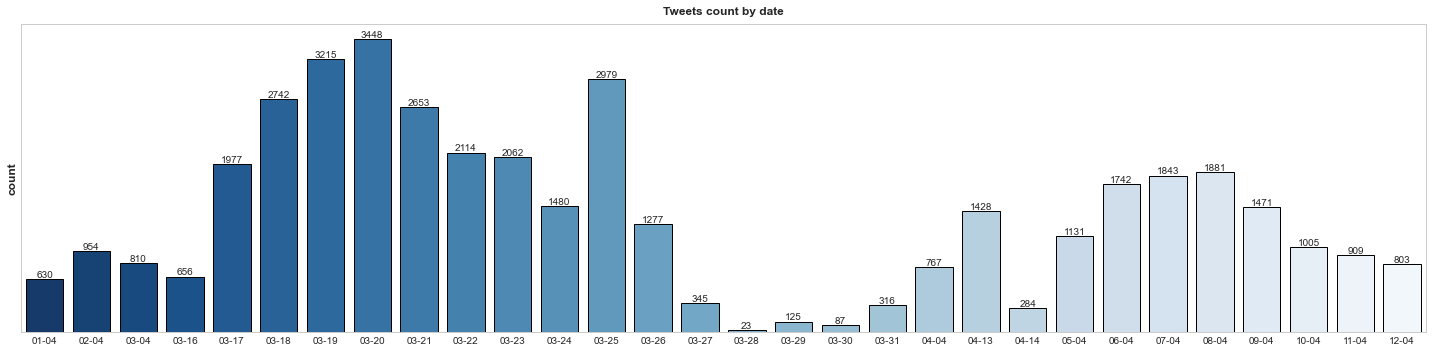

In [14]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We notice that in the dataset there are some days without tweets in the dataset. Among the days with tweets, most of them are made around the end of March: from 18th of Match to the 26th of March.

# Tweets per country and city

In [15]:
tweets_per_country = df['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

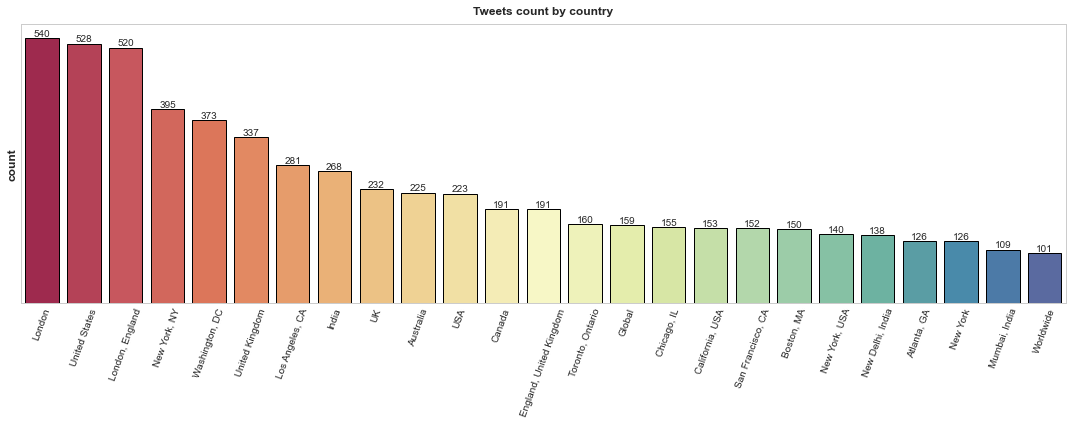

In [16]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x='index', y='counts', data=tweets_per_country,edgecolor = 'black',ci=False, palette='Spectral')
plt.title('Tweets count by country')
plt.xticks(rotation=70)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

The 'location' column contains both countries and cities. It could be interesting to separate cities and countries, however this wont be investigated in this work.

# Tweets Deep Cleaning

In the following, we will perform some data cleaning on the raw text of the tweets.<br>
To simplify the analaysis, we will just keep the columns 'Originaltweet' (raw tweets) and the target column 'Sentiment'.

In [17]:
df = df[['OriginalTweet','Sentiment']]

In [18]:
df_test = df_test[['OriginalTweet','Sentiment']]

**Then we define custom functions to clean the text of the tweets.**

In [19]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [20]:
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

/var/folders/z9/yph7g2dn0d1d7xpfrk71ql7h0000gn/T/ipykernel_1429/605895425.py:5: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji


In [21]:
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

/var/folders/z9/yph7g2dn0d1d7xpfrk71ql7h0000gn/T/ipykernel_1429/605895425.py:5: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji


Now we can create a new column, for both train and test sets, to host the cleaned version of the tweets' text.

In [22]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [23]:
df['text_clean'].head()

0                                              and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: text_clean, dtype: object

In [24]:
df_test['text_clean'].head()

0    trending new yorkers encounter empty supermark...
1    when i couldnt find hand sanitizer at fred mey...
2    find out how you can protect yourself and love...
3    panic buying hits newyork city as anxious shop...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: text_clean, dtype: object

In [25]:
df['text_clean'][1:8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement',
       'as news of the regions first confirmed covid19 case came out of sullivan county last week people 

Moreover, we will also create a column to host the lenght of the cleaned text, to check if by cleaning the text we removed too much text or almost entirely the tweet!

In [26]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [29]:
df['text_len'] = text_len

In [30]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [31]:
df_test['text_len'] = text_len_test

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

As we can see, there are lots of cleaned tweets with 0 words: this is due to the cleaning performed before. This means that some tweets contained only mentions, hashtags and links, which have been removed. We will drop these empty tweets and also those with less than 5 words.

In [27]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (41157, 3)
 DF TEST SHAPE: (3798, 3)


In [32]:
df = df[df['text_len'] > 4]

In [ ]:
df_test = df_test[df_test['text_len'] > 4]

In [33]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (40935, 4)
 DF TEST SHAPE: (3798, 4)


## Training data deeper cleaning

Let's perform a further cleaning checking the tokenizer version of the sentences.

First, we import the BERT tokenizer.

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

Let's check the long tokenized sentences (with more than 80 tokens ):

In [ ]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")  

These sentences are not in english. They should be dropped.

In [ ]:
df['token_lens'] = token_lens

In [ ]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

In [ ]:
df = df.iloc[12:]
df.head()

The dataset looks more clean now. We will shuffle it and reset the index.

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

## Test data deeper cleaning

We will perform the data cleaning based on the tokenized sentences on the test set.

In [ ]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

In [ ]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

In [ ]:
df_test['token_lens'] = token_lens_test

In [ ]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10) 

In [ ]:
df_test = df_test.iloc[5:]
df_test.head(3)

In [ ]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

Now the data cleaning is completed. I will perform more data cleaning if I have new ideas !! :)

# Sentiment column analysis

Now we will look at the target column 'Sentiment'.

In [34]:
df['Sentiment'].value_counts()

Positive              11382
Negative               9890
Neutral                7567
Extremely Positive     6618
Extremely Negative     5478
Name: Sentiment, dtype: int64

The first thing we can do is to encode the categories with numbers. We will also create just 3 possible emotions: Positive, Neutral and Negative.

In [ ]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [ ]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [ ]:
df['Sentiment'].value_counts()

We note that the three classes are imbalanced. We will proceed with oversampling the train test, to remove bias towards the majority classes.

## Class Balancing by RandomOverSampler

In [35]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [36]:
train_os['Sentiment'].value_counts()

Positive              11382
Extremely Negative    11382
Neutral               11382
Negative              11382
Extremely Positive    11382
Name: Sentiment, dtype: int64

## Train - Validation - Test split

In [37]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

A validation set will be extracted from the training set to monitor the validation accuracy, and so prevent overfitting.

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [39]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

## One hot encoding

After performing some tests, by using one hot encoding on the target variable we achieved higher accuracy. For this reason we will choose one hot enconding over label encoding. <br>
EDIT: We will save a copy of the label encoded target columns since they could be useful for further analysis.

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [40]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [41]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 51219
VALIDATION DATA: 5691
TESTING DATA: 3798


In [42]:
y_train.shape

(51219, 5)

# Baseline model: Naive Bayes Classifier

Before implementing BERT, we will define a simple Naive Bayes baseline model to classify the tweets.

First we need to tokenize the tweets using CountVectorizer.

In [43]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

Then we create the TF-IDF (term-frequency times inverse document-frequency) versions of the tokenized tweets.

In [44]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

Now we can define the Naive Bayes Classifier model

In [45]:
nb_clf = MultinomialNB()

In [46]:
nb_clf.fit(X_train_tf, y_train_le)

NameError: name 'y_train_le' is not defined

In [ ]:
nb_pred = nb_clf.predict(X_test_tf)

In [ ]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

**The algorithm performance is not so bad. <br> The F1 score is around 70% for the more populated classes (Negative and Positive emotions), and lower for the Neutral class (F1=0.53).<br>
In particular, the overall accuracy is 70%.**

In the next section we will perform the sentiment analysis using BERT.

# BERT Sentiment Analysis

We already performed a basic analyis of the tokenized sentences, now we just need to define a custom tokenizer function and call the encode_plus method of the BERT tokenizer.

In [ ]:
MAX_LEN=128

In [ ]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

Then, we apply the tokenizer function to the train, validation and test sets.

In [ ]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

# BERT modeling

Now we can import the BERT model from the pretrained library from Hugging face.

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Then, we create a custom function to host the pre trained BERT model, and attach to it a 3 neurons output layer, necessary to perform the classification of the 3 different classes of the dataset (the 3 emotions).

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [ ]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Finally we can start fine tuning the BERT transformer !

In [ ]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

# BERT results

In [ ]:
result_bert = model.predict([test_input_ids,test_attention_masks])

In [ ]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [ ]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

# RoBERTa Sentiment Analysis

As seen for BERT, we first import the tokenizer used to train the original roberta transformer by Facebook.

In [ ]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

First, we check the length of the longest tokenized sentence by roberta tokenizer:

In [ ]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

In [ ]:
MAX_LEN=128

Then we can define the tokenization function

In [ ]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

# RoBERTa modeling

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [ ]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

In [ ]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

In [ ]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30)

# RoBERTa results

In [ ]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

In [ ]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

In [ ]:
conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa Sentiment Analysis\nConfusion Matrix')

In [ ]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

# Results Summary

## BERT Classification Report

In [ ]:
print('Classification Report for BERT:\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

## RoBERTa Classification Report

In [ ]:
print('Classification Report for RoBERTa:\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

## Classification Matrix Comparison

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,5.5))

labels = ['Negative', 'Neutral', 'Positive']
plt.suptitle('Sentiment Analysis Comparison\n Confusion Matrix', fontsize=20)


sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_bert.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[0], annot_kws={"size":25})

ax[0].set_title('BERT Classifier', fontsize=20)
ax[0].set_yticklabels(labels, fontsize=17);
ax[0].set_xticklabels(labels, fontsize=17);
ax[0].set_ylabel('Test', fontsize=20)
ax[0].set_xlabel('Predicted', fontsize=20)

sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_roberta.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[1], annot_kws={"size":25})
ax[1].set_title('RoBERTa Classifier', fontsize=20)
ax[1].set_yticklabels(labels, fontsize=17);
ax[1].set_xticklabels(labels, fontsize=17);
ax[1].set_ylabel('Test', fontsize=20)
ax[1].set_xlabel('Predicted', fontsize=20)


plt.show()

We can see that both the algorithms performed well on the classification task, with performance scores around 90%.

**Thank you for reading my notebook!! Let me know if you have any question or if you want me to check out your works !! :)**